## Processing site pages

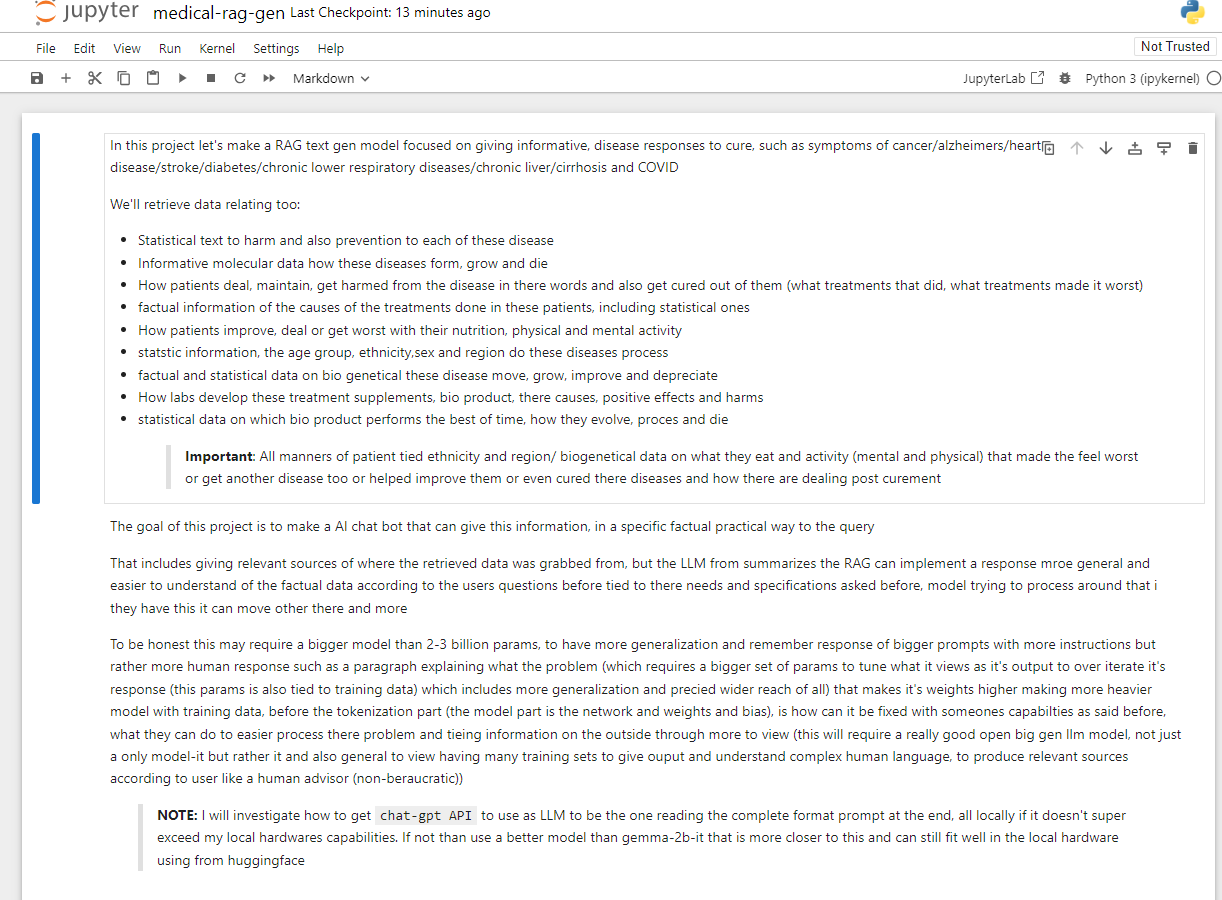

# In this project we'll stick to the top 4 worst diseases 🦠😷
* Cancer
* Heart Disease
* COVID
* Stroke

## Dependencies

In [45]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from tqdm.auto import tqdm
import fitz
from spacy.lang.en import English # Create sentence barrier
from sentence_transformers import SentenceTransformer, util # The embedding model and the metric model to find meaning (similarity search between
# query meaning and the vector data in database from the the sentence chunks we embedded)
# Let's leave the LLM import later so we can know for certain which one we'll use
# Same with BytesAndBytesConfig to know if we need that for LLM, leave it for later, as our hardware isn't able to use flash attention 2
from newspaper import Article
import textwrap

## Our site data

Let's start with sites or articles using the `article()` function

> **let's first do 4 sites per disease topic, in total there is 9 topics. We'll have the model study specifically the top 4 worst and common diseases in the world.**

Due to the combination we'll have to do when grabbing reqeusting or PDF and the amount of sources out theres regarding a specific of a subject. The amount each site we'll get isn't precise but by average it should be 4 sources for every disease on the topic. However, when it involved treatments or cures such as there definitions and growths, There are several compounds that contribute to this process, we had to grab 5 - 6 sources per compound to get as much data on that specific of the subject. So the average in total can vary but since majority of data had other topics besides complete compound on the lab work, by average it's 4 sources per disease 4 - 7

In [46]:
print(f"4 sites for each 4 diseases in 9 topics: {(4 * 4 * 9) / 9} links per topic")

4 sites for each 4 diseases in 9 topics: 16.0 links per topic


In [47]:
forbidden_urls = ["https://acsjournals.onlinelibrary.wiley.com/doi/10.3322/caac.21820",
                 "https://www.sciencedaily.com/releases/2024/01/240124132843.htm#:~:text=Here%20are%20some%20other%20key,the%20U.S.%2C%20including%20heart%20attacks",
                 "https://www.ahajournals.org/doi/10.1161/STROKEAHA.110.596718",
                 "https://www.heart.org/en/health-topics/heart-failure/treatment-options-for-heart-failure/lifestyle-changes-for-heart-failure",
                 "https://www.heart.org/en/health-topics/heart-attack/life-after-a-heart-attack/lifestyle-changes-for-heart-attack-prevention",
                 "https://www.heart.org/en/health-topics/heart-attack/treatment-of-a-heart-attack/cardiac-medications",
                 "https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.105.594986",
                 "https://www.heart.org/en/healthy-living/healthy-lifestyle/stress-management/stress-and-heart-health",
                 "https://www.heart.org/en/news/2020/02/04/chronic-stress-can-cause-heart-trouble",
                 "https://www.ajconline.org/article/0002-9149(92)91168-4/abstract#:~:text=The%20major%20risks%20can%20be,%2C%20hypotension%2C%20and%20myocardial%20rupture.",
                 "https://journals.sagepub.com/doi/10.1177/10600280211073009#:~:text=An%20abundance%20of%20evidence%20supports,patient%20care%20and%20clinical%20practice:",
                 "https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD000024.pub5/full#:~:text=Damage%20from%20a%20stroke%20can,very%20serious%20outcomes%20from%20this.",
                 "https://ascopubs.org/doi/10.1200/JCO.2023.41.16_suppl.10547#:~:text=Background:%20Sex%20differences%20in%20cancer,behavior%20remains%20not%20well%20understood.",
                 "https://www.fredhutch.org/en/patient-care/treatments/immunot",
                 "https://www.heart.org/en/news/2024/04/08/since-losing-her-mom-to-heart-disease-at-53-health-and-fitness-are-her-priorities",
                 "https://www.heart.org/en/news/2024/04/01/walk-this-way-its-quite-good-for-you",
                 "https://www.heart.org/en/news/2024/03/08/more-than-half-of-american-indian-teens-and-young-adults-have-high-cholesterol",
                 "https://pubmed.ncbi.nlm.nih.gov/38230766/",
                 "https://pubmed.ncbi.nlm.nih.gov/38264914/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK9963/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK9840/",
                 "https://pubmed.ncbi.nlm.nih.gov/14593697/#:~:text=Most%20cardiovascular%20diseases%20result%20from,occlusive%20vascular%20disease%2C%20myocardial%20infarction",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10434786/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK539800/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10295542/#:~:text=The%20etiopathogenesis%20of%20myocarditis%20is,toxins)%20factors%20%5B2%5D.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7904902/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10153209/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9866114/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9409332/#:~:text=Ischemic%20stroke%20initiates%20a%20cascade,eventually%20contribute%20to%20cell%20death.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9433609/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9738151/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK401241/#:~:text=%E2%80%9CHematopoietic%E2%80%9D%20means%20%E2%80%9Cblood%2D,the%20body%20via%20a%20drip.",
                 "https://www.ncbi.nlm.nih.gov/books/NBK431051/#:~:text=practice.%5B9%5D-,Heart%20Failure,also%20reduce%20cardiac%20myocyte%20hypertrophy.",
                 "https://www.ncbi.nlm.nih.gov/books/NBK431051/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK532906/#:~:text=Once%20beta%2Dblockers%20bind%20to,have%20a%20potent%20antiarrhythmic%20effect.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9828709/#:~:text=A%20recent%20systematic%20review%20found,these%20programs%20on%20mental%20health.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7922450/#:~:text=Dual%20oxygen%20therapy%20may%20be,using%20an%20extra%20oxygen%20flowmeter.",
                 "https://pubmed.ncbi.nlm.nih.gov/38360929/#:~:text=Both%20pain%20severity%20(ES1%20%3D%200.69,patients%20suffering%20from%20long%20COVID.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9821470/#:~:text=The%20recommended%20treatment%20for%20patients,from%20the%20blood%20%5B7%5D.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10499427/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10289817/#:~:text=The%20prolongation%20of%20oral%20anticoagulant,of%203%20months%20or%20less.",
                 "https://www.ncbi.nlm.nih.gov/books/NBK562154/",
                 "https://pubmed.ncbi.nlm.nih.gov/31186620/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9393649/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK549826/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5809704/#:~:text=Lingering%20anesthesia%20may%20delay%20diagnosis,without%20perioperative%20stroke%20%5B3%5D.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6166309/#:~:text=Risks%20of%20recurrent%20HS%2C%20ischemic,leading%20cause%20of%20death%20worldwide.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5200859/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8215791/#:~:text=A%20range%20of%20ASMs%2C%20especially,stroke%20should%20be%20particularly%20considered.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4515256/",
                 "https://pubmed.ncbi.nlm.nih.gov/30060365/#:~:text=The%20analysis%20showed%20that%20the,and%2064.67%20years%20old%2C%20respectively.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6029678/#:~:text=Cancer%20represents%20a%20leading%20cause,response%20to%20therapy%20of%20cancer.",
                 "https://pubmed.ncbi.nlm.nih.gov/28718431/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9714345/#:~:text=In%20addition%2C%20various%20research%20studies,patients%20in%20China%20(4).",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9395988/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7658622/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4407582/#:~:text=DNA%20damage%20has%20been%20long,avenue%20for%20chemo%2D%20and%20radiotherapy.",
                 "https://www.ncbi.nlm.nih.gov/books/NBK9963/#:~:text=At%20the%20cellular%20level%2C%20the,cells%20of%20the%20tumor%20population.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4463690/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK26902/#:~:text=Many%20cancer%20mutations%20alter%20signal,receptors%2C%20act%20in%20this%20way.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8267781/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9569471/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8043745/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9409332/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8775228/#:~:text=%5B20%5D%20Cerebral%20Autosomal%20Dominant%20Arteriopathy,autosomal%20dominant%20way%20%5B22%5D.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002316/#:~:text=Stroke%20is%20a%20multi%2Dfactorial,the%20complex%20genetics%20of%20stroke.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8296125/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4215696/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5441126/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3345145/#:~:text=Lovastatin%20is%20a%20fermentation%20product,ranges%20from%2035%20to%2055%25.",
                 "https://pubmed.ncbi.nlm.nih.gov/11956737/#:~:text=Natural%20statins%20can%20be%20obtained,and%20mevastatin%20by%20Penicillium%20citrinum.",
                 "https://www.ncbi.nlm.nih.gov/books/NBK430896/#:~:text=Angiotensinogen%20produced%20from%20the%20liver,mineralocorticoid%20receptor%20activity.%5B12%5D",
                 "https://www.ncbi.nlm.nih.gov/books/NBK430940/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK537027/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9600347/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3466827/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK563322/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8584061/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK12772/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7551545/#:~:text=Sir%20Gustav%20Nossal%20then%20proved,antibodies%20%5B5%2C6%5D.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6163118/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7987532/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9785933/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9317404/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9025561/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8624180/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9143071/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8155633/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9052793/",
                 "https://pubmed.ncbi.nlm.nih.gov/38399271/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK563261/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7283864/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK507917/#:~:text=Access%20free%20multiple%20choice%20questions,tissue%20plasminogen%20activators%20(rtPA).",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8222621/",
                 "https://www.ncbi.nlm.nih.gov/books/NBK560651/#:~:text=Anticoagulants%20derive%20their%20effect%20by,(vitamin%20K%20dependent%20factors).",
                 "https://pubmed.ncbi.nlm.nih.gov/32162811/",
                 "https://pubmed.ncbi.nlm.nih.gov/37498576/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7262605/",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8487900/#:~:text=Patient%2Dreported%20outcomes%20(PROs),field%20of%20cardiac%20clinical%20trials.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9331446/#:~:text=The%20coronavirus%20disease%202019%20(COVID,disorders%2C%20particularly%20anxiety%20and%20depression.",
                 "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8787187/"]

In [48]:
urls = ["https://www.cancer.org/research/acs-research-news/facts-and-figures-2022.html",
        "https://www.unitypoint.org/news-and-articles/most-dangerous-cancers-in-men-and-women",
        "https://world-heart-federation.org/what-we-do/prevention/#:~:text=An%20estimated%2080%25%20of%20cardiovascular,disease%20and%20stroke%2C%20is%20preventable",
        "https://www.singlecare.com/blog/news/heart-disease-statistics/",
        "https://www.cdc.gov/respiratory-viruses/background/index.html#:~:text=from%20RESP%2DNET.-,Deaths,%2C%20cancer%2C%20and%20unintentional%20injury",
        "https://www.cdc.gov/stroke/facts.htm",
        "https://www.practiceupdate.com/content/a-2024-update-on-heart-disease-and-stroke-statistics-from-the-american-heart-association/161668",
        "https://cancer.ca/en/cancer-information/what-is-cancer/how-cancer-starts-grows-and-spreads#:~:text=Cancer%20cells%20have%20gene%20mutations,UV)%20radiation%20from%20the%20sun.",
        "https://www.cancer.gov/about-cancer/understanding/what-is-cancer#:~:text=Cancer%20is%20a%20disease%20caused,uncontrolled%20cell%20growth%20and%20cancer.",
        "https://www.merckmanuals.com/professional/hematology-and-oncology/overview-of-cancer/cellular-and-molecular-basis-of-cancer#The-Immune-System-and-Cancer_v39241527",
        "https://www.nhlbi.nih.gov/health/atherosclerosis#:~:text=Atherosclerosis%20develops%20slowly%20as%20cholesterol,an%20artery%20with%20plaque%20buildup.",
        "https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/heart-disease-and-food",
        "https://www.frontiersin.org/articles/10.3389/fcimb.2021.563085/full#:~:text=Host%20protease%20activation%20is%20the,membrane%20fusion%20and%20viral%20infectivity.",
        "https://www.mdpi.com/1422-0067/23/4/1987",
        "https://www.nature.com/articles/s41392-022-01064-1",
        "https://www.nhs.uk/conditions/transient-ischaemic-attack-tia/causes/#:~:text=The%20blockage%20in%20the%20blood,fatty%20material%20or%20air%20bubbles.",
        "https://med.stanford.edu/survivingcancer/coping-with-cancer/coping-with-cancer.html",
        "https://www.mayoclinic.org/diseases-conditions/cancer/in-depth/cancer-diagnosis/art-20044544",
        "https://www.cancerresearchuk.org/about-cancer/coping/family-friends-caregivers/how-support-someone-with-cancer",
        "https://www.cancervic.org.au/get-support/living-with-cancer/life-after-treatment/living-well-after-cancer",
        "https://cancer.ca/en/living-with-cancer/coping-with-changes/your-emotions-and-cancer",
        "https://g.co/gemini/share/0ee3cf6ece0f",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/my-story/fatigue-sarah-fisher",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/my-story/high-blood-pressure-joyce",
        "https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124#:~:text=With%20your%20provider's%20OK%2C%20aim,provider%20about%20strategies%20to%20help.",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/living-with-heart-failure/5-tips-for-managing-heart-failure",
        "https://www.hopkinsmedicine.org/health/conditions-and-diseases/congestive-heart-failure-prevention-treatment-and-research#:~:text=There's%20no%20cure%20for%20heart,conditions%20and%20the%20individual%20patient.",
        "https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/living-with-a-heart-condition",
        "https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/mental-health-covid-19/art-20482731",
        "https://www.unsw.edu.au/newsroom/news/2021/10/how-to-cope-with-your-covid-19-diagnosis",
        "https://caps.umich.edu/article/how-cope-after-learning-someone-you-care-about",
        "https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/treating-covid-19-at-home/art-20483273#:~:text=Many%20people%20with%20COVID%2D19,Fever%20reducers.",
        "https://www.cdc.gov/coronavirus/2019-ncov/your-health/treatments-for-severe-illness.html",
        "https://www.verywellhealth.com/coping-with-stroke-4158490#:~:text=Many%20people%20go%20through%20a,7",
        "https://healthtalk.org/experiences/stroke/coping-strategies-and-resilience/#:~:text=Individuals%20who%20were%20interviewed%20coped,have%20made%20them%20stronger%20individuals.",
        "https://www.flintrehab.com/stroke-affecting-speech-aphasia/",
        "https://www.mountsinai.org/health-library/special-topic/recovering-after-stroke#:~:text=People%20who%20are%20not%20able,someone%20come%20to%20their%20home.",
        "https://www.cdc.gov/stroke/treatments.htm#:~:text=Recovery%20time%20after%20a%20stroke,of%20Neurological%20Disorders%20and%20Stroke.",
        "https://www.cancercare.org/chemo-side-effects?gad_source=1&gclid=CjwKCAjwz42xBhB9EiwA48pT7yv4nVJBxf6FDpLwaUJf9KceRXCRSR15gqSq7SgPQEmuFfw5pYdToRoCF-kQAvD_BwE",
        "https://fightcolorectalcancer.org/living-with-colorectal-cancer/survivorship-care-planning/?gad_source=1&gclid=CjwKCAjwz42xBhB9EiwA48pT7x-KZ5Brzze9_pm_uK2xcCkm0WZHhI4mQbry41k2vJbaSg7tMf0s3BoCp-QQAvD_BwE#sessions",
        "https://www.cancer.net/survivorship/long-term-side-effects-cancer-treatment",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/surgery/risks-of-cancer-surgery.html",
        "https://www.cancer.net/navigating-cancer-care/how-cancer-treated/surgery/side-effects-cancer-surgery",
        "https://www.cancerresearchuk.org/about-cancer/treatment/radiotherapy/side-effects/long-term-side-effects#:~:text=General%20long%20term%20side%20effects&text=your%20skin%20might%20feel%20different,by%20small%20broken%20blood%20vessels",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/radiation/effects-on-different-parts-of-body.html",
        "https://www.cancer.gov/news-events/cancer-currents-blog/2021/immune-checkpoint-inhibitors-melanoma-long-term-side-effects",
        "https://www.cancerresearch.org/immunotherapy-side-effects",
        "https://www.cancer.gov/types/prostate/prostate-hormone-therapy-fact-sheet",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/hormone-therapy.html#:~:text=It's%20also%20important%20to%20balance,Hot%20flashes",
        "https://www.cancer.net/navigating-cancer-care/how-cancer-treated/bone-marrowstem-cell-transplantation/side-effects-bone-marrow-transplant-stem-cell-transplant",
        "https://www.anthonynolan.org/patients-and-families/recovering-a-stem-cell-transplant/late-effects-after-a-stem-cell-transplant",
        "https://www.facingourrisk.org/info/risk-management-and-treatment/cancer-treatment/by-treatment-type/targeted-therapy/side-effects#:~:text=Anemia%2C%20bleeding%20and%20low%20white,blood%20cell%20count%20(neutropenia).",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/targeted-therapy/side-effects.html",
        "https://www.cancer.gov/about-cancer/treatment/types/targeted-therapies#:~:text=Most%20types%20of%20targeted%20therapy,that%20targeted%20therapy%20treats%20cancer.",
        "https://www.cancer.gov/about-cancer/treatment/types/chemotherapy#how-chemotherapy-works-against-cancer",
        "https://www.mayoclinic.org/diseases-conditions/cancer/in-depth/cancer-surgery/art-20044171#:~:text=When%20it's%20possible%2C%20the%20goal,if%20they%20contain%20cancer%20cells.",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/surgery/how-surgery-is-used-for-cancer.html",
        "https://www.cancer.gov/about-cancer/treatment/types/radiation-therapy#:~:text=during%20radiation%20therapy-,How%20radiation%20therapy%20works%20against%20cancer,therapy%2C%20external%20beam%20and%20internal.",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/radiation/basics.html#:~:text=x%2Dray%20therapy.-,What%20is%20radiation%20therapy?,working%20the%20way%20they%20should.",
        "https://www.theros1ders.org/post/what-is-targeted-therapy?gad_source=1&gclid=CjwKCAjwz42xBhB9EiwA48pT72ui0y7Dr0eMFitduwAv4tKf7Gyfmt8RCpKkRdZP13WqmdilYY0VNhoCiJMQAvD_BwE",
        "https://www.cancerresearchuk.org/about-cancer/treatment/targeted-cancer-drugs/what-are-targeted-cancer-drugs",
        "https://www.mayoclinic.org/tests-procedures/chemotherapy/about/pac-20385033",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/immunotherapy/what-is-immunotherapy.html",
        "https://www.yalemedicine.org/conditions/cancer-immunotherapy#:~:text=How%20does%20immunotherapy%20work?,from%20outsmarting%20the%20immune%20system.",
        "https://www.cancer.gov/about-cancer/treatment/types/hormone-therapy",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/hormone-therapy.html",
        "https://www.cancer.gov/about-cancer/treatment/types/stem-cell-transplant#:~:text=Stem%20cell%20transplants%20do%20not,used%20to%20destroy%20cancer%20cells.",
        "https://www.health.harvard.edu/blog/lifestyle-changes-to-lower-heart-disease-risk-2019110218125",
        "https://www.webmd.com/heart-disease/heart-disease-medications",
        "https://www.fda.gov/drugs/drug-safety-and-availability/fda-drug-safety-communication-fda-review-finds-long-term-treatment-blood-thinning-medicine-plavix#:~:text=The%20DAPT%20trial%20showed%20that,receiving%20clopidogrel%20but%20not%20prasugrel.",
        "https://my.clevelandclinic.org/health/drugs/22955-antiplatelet-drugs",
        "https://www.mountsinai.org/health-library/discharge-instructions/heart-failure-medicines",
        "https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/statin-side-effects/art-20046013#:~:text=While%20statins%20are%20highly%20effective,they%20may%20cause%20liver%20damage.",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/statins-fact-or-fiction",
        "https://my.clevelandclinic.org/health/drugs/23327-angiotensin-ii-receptor-blockers",
        "https://www.webmd.com/heart-disease/heart-failure/heart-failure-angiotensin-ii",
        "https://www.pharmacytimes.com/view/long-term-use-of-ace-inhibitors-may-cause-kidney-damage-study-results-suggest",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/drug-cabinet/arbs#:~:text=They're%20also%20used%20in,drugs%20are%20often%20used%20interchangeably.",
        "https://www.healthline.com/health/heart-disease/arbs#benefits",
        "https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/beta-blockers/art-20044522#:~:text=The%20medicines%20block%20the%20effects,arteries%20to%20improve%20blood%20flow.",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/drug-cabinet/beta-blockers#:~:text=Beta%20blockers%20are%20widely%20prescribed,pump%20chamber%20of%20the%20heart).",
        "https://www.emedicinehealth.com/what_are_the_longterm_side_effects_of_betablockers/article_em.htm",
        "https://my.clevelandclinic.org/health/treatments/22318-beta-blockers",
        "https://medlineplus.gov/bloodthinners.html#:~:text=Blood%20thinners%20are%20medicines%20that,different%20types%20of%20blood%20thinners:",
        "https://www.healthline.com/health/heart-disease/blood-thinners#uses",
        "https://www.medicalnewstoday.com/articles/327165#what-are-blood-thinners",
        "https://www.medicalnewstoday.com/articles/blood-thinners#what-are-they",
        "https://www.webmd.com/heart-disease/atrial-fibrillation/afib-blood-thinner-use",
        "https://www.nhs.uk/conditions/coronary-angioplasty/#:~:text=The%20term%20%22angioplasty%22%20means%20using,blood%20to%20flow%20more%20freely.",
        "https://www.nhlbi.nih.gov/health/coronary-artery-bypass-grafting#:~:text=CABG%20uses%20healthy%20blood%20vessels,or%20veins%20from%20the%20legs.",
        "https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/coronary-artery-bypass-graft-surgery#:~:text=One%20way%20to%20treat%20the,called%20coronary%20artery%20bypass%20surgery.",
        "https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/angioplasty-and-stent-placement-for-the-heart",
        "https://my.clevelandclinic.org/health/treatments/23966-heart-valve-replacement",
        "https://www.mayoclinic.org/tests-procedures/heart-valve-surgery/about/pac-20384901#:~:text=To%20replace%20a%20heart%20valve,to%20wear%20out%20over%20time.",
        "https://www.mayoclinic.org/tests-procedures/implantable-cardioverter-defibrillators/about/pac-20384692",
        "https://medlineplus.gov/ency/article/007370.htm#:~:text=A%20cardiologist%20or%20surgeon%20most,made%20near%20your%20left%20shoulder.",
        "https://www.nhlbi.nih.gov/health/pacemakers#:~:text=During%20an%20arrhythmia%2C%20the%20heart,more%20efficiently%20to%20your%20body.",
        "https://www.yalemedicine.org/conditions/cardiac-pacemaker",
        "https://www.nhlbi.nih.gov/health/pacemakers/after#:~:text=Heart%20problems.,other%20parts%20of%20the%20body.",
        "https://www.uptodate.com/contents/cardiac-implantable-electronic-devices-long-term-complications",
        "https://www.reliasmedia.com/articles/complications-of-implantable-cardioverter-defibrillators-in-the-emergency-department-setting#:~:text=Complications%20seen%20shortly%20after%20placement%20include%20bleeding,(often%20leading%20to%20lead%20fracture)%2C%20infection%20(Staphylococcus",
        "https://www.memorialcare.org/services/heart-vascular-care/cardiac-rehabilitation?utm_source=google&utm_medium=paidsearch&utm_campaign=mhvi&utm_term=cardiac%20rehab&customer_id=675-744-9108&gclid=CjwKCAjwz42xBhB9EiwA48pT75WtxvM5YUcqbYT0te_8rYQpdRNFn64DhmIbtqCbr5_iW8Gjrd_feRoCSdMQAvD_BwE",
        "https://www.mayoclinic.org/tests-procedures/cardiac-rehabilitation/about/pac-20385192#:~:text=The%20supervised%20program%20is%20designed,about%20a%20heart%2Dhealthy%20lifestyle.",
        "https://www.cdc.gov/heartdisease/cardiac_rehabilitation.htm#:~:text=Cardiac%20rehabilitation%20can%20have%20many,problems%2C%20such%20as%20chest%20pain.",
        "https://www.hsph.harvard.edu/nutritionsource/disease-prevention/cardiovascular-disease/preventing-cvd/",
        "https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/cholesterol-healthy-eating-tips",
        "https://www.cdc.gov/nutrition/resources-publications/benefits-of-healthy-eating.html",
        "https://www.hopkinsmedicine.org/health/wellness-and-prevention/exercise-and-the-heart",
        "https://www.hopkinsmedicine.org/health/wellness-and-prevention/3-kinds-of-exercise-that-boost-heart-health",
        "https://www.cdc.gov/physicalactivity/basics/pa-health/index.htm#:~:text=Being%20physically%20active%20can%20improve,ability%20to%20do%20everyday%20activities.",
        "https://www.ucsfhealth.org/education/weight-management-for-a-healthy-heart",
        "https://www.betterhealth.vic.gov.au/health/conditionsandtreatments/heart-disease-and-food",
        "https://www.health.harvard.edu/heart-health/5-ways-to-de-stress-and-help-your-heart#:~:text=July%2024%2C%202023,disease%20in%20more%20subtle%20ways.",
        "https://www.mayoclinic.org/healthy-lifestyle/stress-management/in-depth/stress/art-20046037#:~:text=There%20are%20many%20rewards%20for,to%20a%20longer%2C%20healthier%20life.",
        "https://health.gov/myhealthfinder/health-conditions/heart-health/manage-stress",
        "https://www.covid19treatmentguidelines.nih.gov/therapies/immunomodulators/systemic-corticosteroids/#:~:text=Hydrocortisone%20is%20commonly%20used%20to,for%20Adults%20for%20more%20information.",
        "https://www.ccjm.org/content/early/2020/08/18/ccjm.87a.ccc059#:~:text=Previous%20trials%20and%20meta%2Danalysis,effects%20include%20hyperglycemia%20and%20hypernatremia.&text=Dexamethasone%20has%20minimal%20mineralocorticoid%20activity,a%20key%20problem%20in%20ARDS.",
        "https://bmcinfectdis.biomedcentral.com/articles/10.1186/s12879-023-08424-4",
        "https://ics.ac.uk/resource/treating-covid-patients-with-oxygen.html#:~:text=Some%20people%20with%20COVID%20have,via%20a%20simple%20face%20mask.",
        "https://www.nature.com/articles/s41598-024-53091-3",
        "https://www.medicinenet.com/when_does_a_covid-19_patient_need_a_ventilator/article.htm",
        "https://annalsofintensivecare.springeropen.com/articles/10.1186/s13613-021-00929-y",
        "https://www.covid19treatmentguidelines.nih.gov/therapies/antithrombotic-therapy/#:~:text=In%20hospitalized%20patients%2C%20LMWH%20or,effects%20can%20be%20reversed%20quickly.",
        "https://www.memorialhermann.org/services/treatments/monoclonal-antibody-therapy#:~:text=Monoclonal%20antibody%20therapy%20(also%20called,for%20developing%20more%20serious%20symptoms.",
        "https://www.houstonmethodist.org/blog/articles/2021/jan/what-is-monoclonal-antibody-therapy-and-who-is-eligible-to-receive-it/",
        "https://www.gavi.org/vaccineswork/lifesaving-unaffordable-pros-and-cons-newest-covid-19-treatment?gad_source=1&gclid=CjwKCAjwz42xBhB9EiwA48pT7z1io0ClHB0dg7vfnaR94Z5oFp7j2OzU12yh15J12Fgk5rwnUq3WWhoCj2UQAvD_BwE",
        "https://gladstone.org/news/patients-long-covid-immune-cells-dont-follow-rules?gad_source=1&gclid=CjwKCAjwz42xBhB9EiwA48pT7ypQHGtbI_yympOqaHvleuYrU53NNQSgfHyP6GdMcx1rOI5yIXQhdRoC1TgQAvD_BwE",
        "https://www.mayoclinic.org/tests-procedures/convalescent-plasma-therapy/about/pac-20486440#:~:text=COVID%2D19%20convalescent%20plasma%20with,that%20causes%20COVID%2D19%20afterward.",
        "https://www.covid19treatmentguidelines.nih.gov/therapies/antivirals-including-antibody-products/covid-19-convalescent-plasma/",
        "https://g.co/gemini/share/3deb75711f6c",
        "https://dellmed.utexas.edu/news/newer-generation-clot-busting-medication-reduces-brain-bleeding-by-half-in-stroke-patients-study-finds#:~:text=The%20vast%20majority%20of%20those,clinicians%20to%20treat%20ischemic%20strokes.",
        "https://www.nhs.uk/conditions/stroke/treatment/",
        "https://newsroom.heart.org/news/newer-generation-clot-busting-stroke-medication-cuts-the-risk-of-serious-bleeding-in-half",
        "https://medlineplus.gov/ency/article/007089.htm#:~:text=This%20helps%20restart%20blood%20flow,and%20stenting%2C%20may%20be%20needed.",
        "https://www.healthline.com/health/living-with-atrial-fibrillation/advancements/long-term-blood-thinner-use",
        "https://www.nhs.uk/conditions/anticoagulants/",
        "https://www.flintrehab.com/stroke-surgery/#:~:text=Once%20administered%2C%20tPA%20helps%20dissolve,a%20mechanical%20embolectomy%20or%20thrombectomy.",
        "https://www.nm.org/conditions-and-care-areas/treatments/surgical-treatments-for-hemorrhagic-stroke#:~:text=Treatment%20of%20hemorrhagic%20stroke%20focuses,of%20bleeding%20is%20large%20enough.",
        "https://www.aans.org/Patients/Neurosurgical-Conditions-and-Treatments/Stroke",
        "https://www.news-medical.net/news/20130212/Strokes-that-occur-during-or-shortly-after-surgery-can-be-devastating.aspx#:~:text=Risk%20factors%20for%20peroperative%20stroke,increase%20the%20risk%20of%20bleeding.",
        "https://emedicine.medscape.com/article/1916662-treatment?form=fpf",
        "https://www.medicalnewstoday.com/articles/common-medications-high-blood-pressure-long-term-health-risk#:~:text=A%20recent%20study%20found%20three,an%20increased%20risk%20for%20stroke.",
        "https://www.verywellhealth.com/stroke-induced-seizures-and-epilepsy-after-strokes-3146425",
        "https://www.cdc.gov/stroke/treatments.htm#:~:text=What%20is%20stroke%20rehabilitation%3F,lost%20because%20of%20the%20stroke.",
        "https://www.mayoclinic.org/diseases-conditions/stroke/in-depth/stroke-rehabilitation/art-20045172",
        "https://www.mayoclinic.org/diseases-conditions/stroke/in-depth/stroke-rehabilitation/art-20045172",
        "https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/stroke-recovery-timeline#:~:text=First%20Few%20Weeks%20After%20a,Heavy%20fatigue%20and%20trouble%20sleeping",
        "https://www.mayoclinic.org/diseases-conditions/stroke/in-depth/stroke-rehabilitation/art-20045172#:~:text=Stroke%20rehabilitation%20is%20a%20program,improve%20your%20quality%20of%20life.",
        "https://www.cancercenter.com/community/blog/2023/06/cancer-risk-by-age#:~:text=The%20average%20age%20of%20individuals,continues%20to%20increase%20with%20age.",
        "https://www.wcrf.org/cancer-trends/worldwide-cancer-data/#:~:text=Global%20cancer%20statistics%20for%20the,challenges%20of%20the%2021st%20century.",
        "https://news.cancerresearchuk.org/2022/03/02/first-data-in-a-decade-highlights-ethnic-disparities-in-cancer/#:~:text=This%20latest%20analysis%2C%20which%20is,cancer%20is%20just%20the%20start.",
        "https://www.kff.org/racial-equity-and-health-policy/issue-brief/racial-disparities-in-cancer-outcomes-screening-and-treatment/#:~:text=Black%20people%20are%20at%20the,survival%20for%20most%20cancer%20types.",
        "https://www.regionalcancercare.org/news/how-race-ethnicity-can-increase-the-risk-of-getting-cancer/",
        "https://www.wcrf.org/cancer-trends/global-cancer-data-by-country/#:~:text=Global%20cancer%20incidence%3A%20both%20sexes,(New%20Caledonia)%20and%20Slovenia.",
        "https://www.who.int/news/item/01-02-2024-global-cancer-burden-growing--amidst-mounting-need-for-services",
        "https://www.medicalnewstoday.com/articles/heart-attack-age-range#incidence-rate",
        "https://g.co/gemini/share/489dfaaed995",
        "https://gh.bmj.com/content/2/2/e000298",
        "https://my.clevelandclinic.org/health/articles/23051-ethnicity-and-heart-disease",
        "https://worldpopulationreview.com/country-rankings/heart-disease-rates-by-country",
        "https://finance.yahoo.com/news/15-countries-highest-number-heart-143433389.html",
        "https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/coronavirus-who-is-at-risk/art-20483301#:~:text=People%20age%2065%20and%20older,which%20adds%20to%20their%20risk.",
        "https://www.pewresearch.org/short-reads/2020/04/22/populations-skew-older-in-some-of-the-countries-hit-hard-by-covid-19/",
        "https://www.cdc.gov/mmwr/volumes/69/wr/mm695152a8.htm#:~:text=In%20June%2C%20incidence%20increased%20in,aged%200%E2%80%9317%20years).",
        "https://www.cdc.gov/coronavirus/2019-ncov/hcp/clinical-care/underlyingconditions.html#:~:text=Based%20on%20data%20from%20the,in%20those%20ages%2075%E2%80%9384",
        "https://www.kff.org/coronavirus-covid-19/issue-brief/covid-19-cases-deaths-and-vaccinations-by-race-ethnicity-as-of-winter-2022/#:~:text=Racial%20disparities%20in%20COVID%2D19,people%20over%20most%20of%20the",
        "https://www.kff.org/racial-equity-and-health-policy/issue-brief/covid-19-cases-and-deaths-by-race-ethnicity-current-data-and-changes-over-time/",
        "https://www.healthline.com/health/age-range-for-stroke#stroke-risk-by-age-range",
        "https://lipidworld.biomedcentral.com/articles/10.1186/s12944-019-1010-y#:~:text=We%20followed%2040%2C560%20person%2Dyears,2).",
        "https://www.nichd.nih.gov/health/topics/stroke/conditioninfo/risk#:~:text=Ischemic%20strokes%20make%20up%20about,less%20risk%20than%20African%20Americans.",
        "https://www.fic.nih.gov/News/GlobalHealthMatters/january-february-2019/Pages/global-stroke-risk.aspx",
        "https://www.cancer.gov/about-cancer/causes-prevention/genetics#:~:text=Cancer%20itself%20can't%20be,you%20will%20definitely%20get%20cancer.",
        "https://www.cancer.net/navigating-cancer-care/cancer-basics/genetics/genes-and-cancer#:~:text=The%20mutation%20is%20in%20one,Not%20necessarily.",
        "https://cancer.ca/en/cancer-information/what-is-cancer/how-cancer-starts-grows-and-spreads#:~:text=Diagram%20of%20cell%20division,cells%20so%20they%20stay%20immature.",
        "https://www.cancerresearchuk.org/about-cancer/what-is-cancer/how-cancer-starts",
        "https://www.pennmedicine.org/news/news-releases/2017/july/how-dna-damage-turns-immune-cells-against-cancer",
        "https://www.cancer.gov/about-cancer/understanding/what-is-cancer#:~:text=Genetic%20changes%20that%20cause%20cancer%20can%20be%20inherited%20or%20arise,and%20spread%20into%20surrounding%20tissues.",
        "https://g.co/gemini/share/ce4ed7179938",
        "https://www.cancerresearchuk.org/about-cancer/what-is-cancer/how-cancer-starts/cancer-cells",
        "https://covid19.nih.gov/news-and-stories/delivering-extra-protection-against-covid-19#:~:text=SARS%2DCoV%2D2%2C%20the,can%20infect%20the%20human%20cells.",
        "https://imb.uq.edu.au/science-stroke",
        "https://www.cancer.net/research-and-advocacy/introduction-cancer-research/how-are-cancer-drugs-discovered-and-developed",
        "https://winshipcancer.emory.edu/magazine/issues/2017/spring/features/how-cancer-drug-gets-to-market/index.html#:~:text=Long%20before%20a%20new%20drug,or%20interferes%20with%20fetal%20development.",
        "https://www.cancer.gov/news-events/cancer-currents-blog/2019/cancer-drugs-natural-products-nci-program#:~:text=Paclitaxel%20(Taxol)%2C%20for%20example,from%20compounds%20found%20in%20fungi.",
        "https://www.healthline.com/health/cancer/what-is-chemotherapy-made-of#ingredients",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/drug-cabinet/arbs",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/drug-cabinet/ace-inhibitors#:~:text=ACE%20inhibitors%20can%20reduce%20the,efficient%2C%20your%20kidneys%20also%20suffer.",
        "https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/ace-inhibitors/art-20047480",
        "https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/drug-cabinet/beta-blockers#:~:text=Beta%20blockers%2C%20also%20called%20beta,is%20pumped%20around%20your%20body.",
        "https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/beta-blockers/art-20044522",
        "https://my.clevelandclinic.org/health/treatments/24984-tyrosine-kinase-inhibitors",
        "https://www.macmillan.org.uk/cancer-information-and-support/treatments-and-drugs/tyrosine-kinase-inhibitors-for-chronic-myeloid-leukaemia",
        "https://www.britannica.com/science/alkylating-agent",
        "https://www.cancer.gov/about-cancer/treatment/types/immunotherapy/monoclonal-antibodies#:~:text=Monoclonal%20antibodies%20are%20immune%20system%20proteins%20that,and%20the%20side%20effects%20they%20may%20cause.",
        "https://my.clevelandclinic.org/health/treatments/22246-monoclonal-antibodies",
        "https://www.cancer.org/cancer/managing-cancer/treatment-types/immunotherapy/monoclonal-antibodies.html",
        "https://www.mayoclinic.org/diseases-conditions/cancer/in-depth/monoclonal-antibody/art-20047808",
        "https://www.cancerresearchuk.org/about-cancer/treatment/immunotherapy/types/monoclonal-antibodies",
        "https://www.cancer.gov/about-cancer/treatment/types/immunotherapy/checkpoint-inhibitors#:~:text=These%20proteins%20are%20called%20immune,its%20partner%20protein%20PD%2DL1.",
        "https://www.mdanderson.org/treatment-options/immune-checkpoint-inhibitors.html#:~:text=D.,of%20patients%20with%20advanced%20melanoma.",
        "https://www.cancerresearchuk.org/about-cancer/treatment/immunotherapy/types/checkpoint-inhibitors",
        "https://www.mskcc.org/coronavirus/what-s-different-about-messenger-rna-vaccines-covid-19",
        "https://medlineplus.gov/genetics/understanding/therapy/mrnavaccines/",
        "https://www.pfizer.com/science/innovation/mrna-technology",
        "https://www.who.int/news-room/feature-stories/detail/the-race-for-a-covid-19-vaccine-explained",
        "https://www.medicalnewstoday.com/articles/covid-19-how-do-inactivated-vaccines-work#Making-inactivated-vaccines",
        "https://www.energy.gov/science/bes/articles/researchers-use-novel-approach-design-covid-19-antiviral-drug",
        "https://www.anl.gov/article/advanced-photon-source-helps-pfizer-create-covid19-antiviral-treatment",
        "https://www.verywellhealth.com/tissue-plasminogen-activator-tpa-3146225#:~:text=Chris%20Ryan%20/%20Getty%20Images,77%25%20between%201969%20and%202013.",
        "https://www.ninds.nih.gov/about-ninds/what-we-do/impact/ninds-contributions-approved-therapies/tissue-plasminogen-activator-acute-ischemic-stroke-alteplase-activaser",
        "https://my.clevelandclinic.org/health/treatments/22288-anticoagulants",
        "https://www.cancer.gov/news-events/cancer-currents-blog/2020/breast-cancer-survival-exercise",
        "https://www.cancer.gov/about-cancer/causes-prevention/risk/obesity/physical-activity-fact-sheet",
        "https://www.cancer.gov/news-events/press-releases/2015/peak-longevity-physical-activity",
        "https://www.cancer.gov/rare-brain-spine-tumor/living/self-care/mental-health",
        "https://www.cancer.gov/news-events/cancer-currents-blog/2020/lung-cancer-treating-mental-health-longer-survival",
        "https://www.cancer.org/research/acs-research-highlights/cancer-health-disparities-research/exercise-and-sitting-time-vary-by-race-and-birthplace.html#:~:text=Specifically%2C%20compared%20with%20White%20Americans,not%20being%20physically%20active%20enough.",
        "https://www.cancer.gov/about-cancer/understanding/disparities",
        "https://openheart.bmj.com/content/6/1/e000920",
        "https://wwwnc.cdc.gov/eid/article/28/11/22-0072_article",
        "https://www.cdc.gov/healthyweight/index.html",
        "https://www.cdc.gov/physicalactivity/basics/adults/index.htm",
        "https://www.cdc.gov/heartdisease/atrial_fibrillation.htm",
        "https://www.cdc.gov/cholesterol/about.htm",
        "https://www.cdc.gov/bloodpressure/about.htm"]
        
len(urls)

225

There may be less the amount of list but thats because some topic data are more expressed in `pdf or txt`, than on a typical site or article, so this measure of links per topic is not very accurate since we'll get several sources from the PDF's that we couldn't scrap from the site page text

- There wasn't much sources about covid harm and prevention statistics online, the best sources was from 1 site and a pdf
- For **strokes** there isn't a lot of statistical data on cases that harmed since strokes are mixed with heart diseases, so strokes can have a bit of limiting data but heart disease other causes can lead to stroke so heart disease makes stroke often
- We Have 10 Sites for the first topic
- Since covid is a virus and not a disease or sickness as much, in the case for patient handling wasn't entirely reliable since the preventive measure to minimize our cure covid is getting vaccinated or doing healthy practices, which have already been explained on `patient cooping` so in the informative treatment part, we will just be repeating what we said on `patient cooping` with what we said on `informative treatments`.
- Most of the information regarding the cells mutation, origin or weakening for covid (SAR-COV-2 Virus) was found more in `PDF` than on websites.
- Majority of the data for lab drugs (develop and discover) was mostly grabbed on `PDF` more than websites.
- > For the important section regarding the patient ethnicity, activity and nutrition. This part of the data was more messy (froms sites to pdf) there isn't more than 1 form of data format that the other and it is just more all over the place. There wasn't either any viable patient records of what activity they did to improve there state out of the disease or sickness (virus) and neither data on what worsen it. There wasn't any data to on ethnicity culuture eating that made someones disease worst. Marjority of the data that was grabbed for this section is a bit mixed with what was grabbed much before with patient dealing and ethnicity involving statistics. A bit of the data here was mixed with those too.

## Get the text from all the data in a list of dictionaries

Each dictionary is representing an site page

dictionary contains:

* link url to that page
* word total count on that page
* character total count on that page
* token total count of that page (`char / 4 = 1 token`)
* text to that page

#### We need to bring all the text first from webpages using `newspaper` to grab the text on html, and send it to a list of dictionaries for us being formatted.

First though. Let's try to functionize this whole step including the raw data imports, all the way to when we embed it finally with the embedding model (this includes embedding our data from pages into a vector database "numeric form")

**All in 1 function**

In [53]:
import re
def text_formatter(text: str): # -> str
    """
    Formats raw texts from sites to remove unwanted char for our pipeline
    """

    formatted_text = text.replace("\n", ' ').strip() # strip will remove just any big spaces that the raw text was carrying
    formatted_text = formatted_text.replace("\xa0", ' ').strip()
    return formatted_text

In [54]:
import time
import os

When you append 2 list together and they contain dictionaries, the list cancel out which you have 1 list containing all the dictionaries of those 2 list.

That's fantastic for use, making this whole concatanation simplier for site pages and pdf's in one single list of `dicts`

### Let's functionize if now from: list(dict) the raw data --> embedding complete processed data into numeric form

In vectors (tensors)

Let's also load the pdfs with the sites

> We should get the API key for NCBI Website publication because the allow for non api-s 3 request per second and thats pretty slow. Let's increase it so that we can request 10 per second, we need the API key to do that though.
>
> NCBI is the only one giving me an issue for the text content to show on their webpages (their require lower run request)
>
> Here is the API Key: `413cb0f20c9e9097829930093fc8c48c9008`
>
> Here is their docs on this: https://www.ncbi.nlm.nih.gov/books/NBK25497/
>
>> **Important:** In a normal situation we'd just pass the API keys but i was blocked from access on any request for any article in NCBI website. I have to authenticate with a copyright to them according to several articles we'd requested. For this project alone we'll just pass all the text content on pdf form so we can avoid the restricted access on the site.

In [55]:
# ncbi_api_key = "413cb0f20c9e9097829930093fc8c48c9008"

In [56]:
# Let's start the function
def raw_data_conversion(input_urls,
                        pdfs_folder):
    """
    Completely collects the raw data from the site pages and pdfs, converts both into a list of 
    dictionaraies. Combines both list into 1 list filled with all the dictionaries, than places
    it in a dataframe, saves it locally and returns back the dataframe to the function.
    """

    # Get pdf path names locally
    def pdf_paths_locally(pdfs_folder):
        """
        Collects all the pdf paths inside many folders locally and returns all paths in a list.
        """

        pdf_paths = []
        
        # Iterate through all files in the pdf folder and its subdirectories
        for root, dirs, files in os.walk(pdfs_folder): # root is / in our pdf_folder, dirs is the whole directory of it pdf or in some case dir/andir
            # files is the files in those folder being the directories which is why i said 'dir/andir'
            for file_name in files:
                # Check if the file is a PDF file
                if file_name.endswith('.pdf'):
                    # Contrust the full filepath
                    file_path = os.path.join(root, file_name)
                    # Process the PDf file here
                    pdf_paths.append(file_path)

        return pdf_paths
    
    # Get newspaper to read our raw pages text
    
    def pdf_text_extract(pdf_paths):
        """
        Extracts the raw text from site pages and pdf using newspaper and fitz
        """
    
        # convert pdfs into a dictionary filled with text criterias using fitz
        pdf_pages_text = []
        
        for pdf in pdf_paths:
            doc = fitz.open(pdf)
            for page_number, page in enumerate(doc):
                text = page.get_text()
                text = text_formatter(text)
                pdf_pages_text.append(
                    {"link_or_page_number": page_number,
                     "page_char_count": len(text),
                     "page_word_count": len(text.split(" ")),
                     "page_sentence_count": len(text.split(". ")),
                     "page_token_count": len(text) / 4,
                     "text": text}
                )
    
        return pdf_pages_text
        

    # Let's functionize the site data extraction
    def sitepages_text_extraction(input_urls):
        """
        Extracts text content from webpages and articles. Places
        it in a list[dict]
        """
        sitepages_and_text = []
        
        for url in input_urls:
            article = Article(url)
            article.download()
            article.parse()
            text = article.text
            text = text_formatter(text)
            sitepages_and_text.append(
                {"link_or_page_number": url,
                 "page_char_count": len(text),
                 "page_word_count": len(text.split(" ")),
                 "page_sentence_count": len(text.split(". ")),
                 "page_token_count": len(text) / 4,
                 "text": text}
            )

        return sitepages_and_text

    # Get our pdf_path list
    # pdfs_folder = ".\pdf"
    pdf_paths = pdf_paths_locally(pdfs_folder=pdfs_folder)

    # Get the text content of each pdf
    pdf_pages_text_list = pdf_text_extract(pdf_paths=pdf_paths)

    # Get the text content on sitepages
    site_page_text_list = sitepages_text_extraction(input_urls=input_urls)

    # Let's combine both pdf and site dictionaries into 1 list
    whole_sitepages_pdf_text = pdf_pages_text_list + site_page_text_list

    # Convert the whole list[dict] into a dataframe
    df = pd.DataFrame(whole_sitepages_pdf_text)
    df.to_csv("./data-processing/whole_sitepages_pdf_text_df.csv", index=False)
    return df

In [57]:
%%time
# Let's get our folder containing all the pdfs for the project
pdfs_folder = ".\pdf"
data_df = raw_data_conversion(urls, pdfs_folder)

CPU times: total: 58.9 s
Wall time: 3min


I've noticed several times. When we request several sources. We get timed out. Later in the future we should catch these errors and except it to let the program iterate through all the other sources. After all sources are loaded and requested, than we can check all the ones that brought an error by placing them in say a seperate error list during the iteration of all the request (`This can be done say at the end of the for loop) and run them again once the all the others have been loaded. This can be done even in a code block below all the request

> It can be a code like this: `if response != 200:
    > error_list.append(text "This is a list of the text content, this text content can be added to a list, so that our text content can be positions 
      by each error and there code response of the type of error")`

## We have our dataframe!

Let's load the one that was saved locally to keep our script secure

In [62]:
data_df.loc[0]['text']

'1.  Checkpoints Inhibitors: Checkpoint inhibitors are drugs that target molecules  such as PD-1 or CTLA-4 on immune cells. These molecules act as brakes on the  immune system, preventing it from attacking normal cells. By blocking these  checkpoints, checkpoint inhibitors can "release the brakes" on the immune  system, allowing it to recognize and attack cancer cells, weakening them. 2.  Targeted Therapies: Targeted therapies are drugs that target speciﬁc molecules  or pathways that are critical for cancer cell growth and survival. For example,  tyrosine kinase inhibitors (TKIs) target enzymes called tyrosine kinases, which  are involved in cell signaling pathways that promote cancer growth. By  inhibiting these enzymes, targeted therapies can weaken cancer cells. 3.  Apoptosis Inducers: Apoptosis is a process of programmed cell death that  eliminates damaged or abnormal cells. Some drugs, known as apoptosis  inducers, can trigger this process in cancer cells, leading to their death. 

In [65]:
the_df = pd.read_csv("./data-processing/whole_sitepages_pdf_text_df.csv")
the_dict = new_df.to_dict(orient="records")
the_dict_df = pd.DataFrame(the_df)
the_dict_df.loc[0]['text']

'1.  Checkpoints Inhibitors: Checkpoint inhibitors are drugs that target molecules  such as PD-1 or CTLA-4 on immune cells. These molecules act as brakes on the  immune system, preventing it from attacking normal cells. By blocking these  checkpoints, checkpoint inhibitors can "release the brakes" on the immune  system, allowing it to recognize and attack cancer cells, weakening them. 2.  Targeted Therapies: Targeted therapies are drugs that target speciﬁc molecules  or pathways that are critical for cancer cell growth and survival. For example,  tyrosine kinase inhibitors (TKIs) target enzymes called tyrosine kinases, which  are involved in cell signaling pathways that promote cancer growth. By  inhibiting these enzymes, targeted therapies can weaken cancer cells. 3.  Apoptosis Inducers: Apoptosis is a process of programmed cell death that  eliminates damaged or abnormal cells. Some drugs, known as apoptosis  inducers, can trigger this process in cancer cells, leading to their death. 

In [67]:
the1_dict = the_dict_df.to_dict(orient="records")
the1_dict[:2], the_dict[:2]

([{'link_or_page_number': '0',
   'page_char_count': 2139,
   'page_word_count': 345,
   'page_sentence_count': 24,
   'page_token_count': 534.75,
   'text': '1.  Checkpoints Inhibitors: Checkpoint inhibitors are drugs that target molecules  such as PD-1 or CTLA-4 on immune cells. These molecules act as brakes on the  immune system, preventing it from attacking normal cells. By blocking these  checkpoints, checkpoint inhibitors can "release the brakes" on the immune  system, allowing it to recognize and attack cancer cells, weakening them. 2.  Targeted Therapies: Targeted therapies are drugs that target speciﬁc molecules  or pathways that are critical for cancer cell growth and survival. For example,  tyrosine kinase inhibitors (TKIs) target enzymes called tyrosine kinases, which  are involved in cell signaling pathways that promote cancer growth. By  inhibiting these enzymes, targeted therapies can weaken cancer cells. 3.  Apoptosis Inducers: Apoptosis is a process of programmed cell 

### Let's keep our formatted data into a dictionary that we can maniuplate it easier

We got our data on each key, let's add a sentenicer to create sentence barriers

**Let's add SpaCy sentencizer** In our main jupyter notebook now